# DATA722 - PROJET VISUALISATION

## Import des modules nécessaires au projet

In [59]:
import json
import os
import itertools
import plotly.express as px
import pandas as pd
import networkx as nx
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from collections import defaultdict
import plotly.figure_factory as ff
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster import hierarchy


files_name = [file_name for file_name in os.listdir('./all') if '.json' in file_name]

## Définitions des fonctions

In [73]:
# Fonction récupérant le nombre d'appartion de chaque localisation en fonction d'une localisation prise en paramètre
def filterByLocKeyWord(keyWord: str, dicLoc: dict, allLocKey: dict, data: dict) -> None:
    data_all = data["data-all"]
    for year in data_all:
        for month in data_all[year]:
            for date in data_all[year][month]:
                if keyWord in data_all[year][month][date][0]["loc"]:
                    for loc in data_all[year][month][date][0]["loc"]:
                        if  (loc in allLocKey):
                            dicLoc[loc] = dicLoc[loc] + 1

# Fonction récupérant le nombre d'appartion de chaque localisation en fonction d'une localisation prise en paramètre
def filterByLocKeyAndValues(keyWord: str, top9key: list, data_all: dict, d_final, lValues) -> None:
    for year in data_all:
        for month in data_all[year]:
            for date in data_all[year][month]:
                for articleN in range(len(data_all[year][month][date])):
                    if keyWord in data_all[year][month][date][articleN]["loc"]:
                        for loc in data_all[year][month][date][articleN]["loc"]:
                            if loc in top9key:
                                kws = data_all[year][month][date][articleN]["kws"]
                                for k in range(len(lValues)):
                                    if lValues[k] in kws:
                                        d_final[year][loc][lValues[k]] += kws[lValues[k]]

# Retourne les localisations en fonction du dictionnaire des localisations
def getLocationKey(allLocKey) -> dict:
    dictLoc = dict.fromkeys(list(allLocKey), 0)
    return dictLoc

# Conversion tuple/dictionnaire
def convertTupleToDict(listTuple):
    dico = {}
    for tuple in listTuple:
        dico[tuple[0]] = tuple[1]
    return dico

# Nettoyage et de triage d'un dictionnaire
def cleanDict(dictionary) -> dict:    
    keys = list(dictionary.keys())
    for key in keys:
        if dictionary.get(key)==0:
            dictionary.pop(key)
    sortedTuple = sorted(dictionary.items(), key=lambda x:x[1], reverse=True)
    return convertTupleToDict(sortedTuple) 

# Récupère les n premiers éléments du dictionnaire
def firstElements(dictionary,n):
    sortedTuple = sorted(dictionary.items(), key=lambda x:x[1], reverse=True)
    return dict(list(sortedTuple[0: n+1]))

# Récupère les éléments du dictionnaire dont la valeur est supérieure au seuil s 
def firstElementsValues(dictionary,s):
    res = []
    sortedTuple = sorted(dictionary.items(), key=lambda x:x[1], reverse=True)
    for tuples in sortedTuple:
        if tuples[1] >= s:
            res.append(tuples)
    return dict(list(res))

# Récupère le dictionnaire des localisations apparaissant dans tout les articles lorsque l'on parle de 'locKws'
def recupLoc(locKws):
    dictionaryLoc = {}
    for file in os.listdir("./all"):
        f = open(f'./all/{file}', 'r', encoding='utf-8')
        data = json.loads(f.read())
        f.close()
        allLocKey = data["metadata-all"]["fr"]["all"]["loc"].keys()
        dicLoc = getLocationKey(allLocKey)
        filterByLocKeyWord(locKws, dicLoc, allLocKey, data)
        dictionaryLoc = Counter(dictionaryLoc) + Counter(dicLoc)
    return dictionaryLoc

# Récupère les mots clé en relations avec deux localisations
def getKeywordsByCountries(country1: str, country2: str, data: dict) -> dict:   
    dict_kws = {}
    dict_apparition = {}
    data_all = data["data-all"]
    for year in data_all:
        for month in data_all[year]:
            for date in data_all[year][month]:
                for article in data_all[year][month][date]:
                    article_location = article["loc"]
                    if (country1 in article_location) and (country2 in article_location):
                        keywords = article["kws"]
                        for kws in keywords:
                            if kws in dict_apparition.keys():
                                dict_apparition[kws] += 1
                            else:
                                dict_apparition[kws] = 1
                        dict_kws = Counter(dict_kws) + Counter(keywords)
    return dict_kws, dict_apparition    

# Parcours des articles et récupération des mots clés et de leurs nombres d'apparition
def recupKws(country1, country2):
    all_kws = {}
    all_apparition = {}
    for file in files_name:
        f = open(f'./all/{file}', 'r', encoding='utf-8')
        data = json.loads(f.read())
        f.close()
        years = data["metadata-all"]["fr"]["year"]
        dict_kws, dict_apparition = getKeywordsByCountries(country1, country2, data)
        all_kws = Counter(all_kws) + Counter(dict_kws)
        all_apparition = Counter(all_apparition) + Counter(dict_apparition)
    return all_kws, all_apparition

# Création du Dataframe pour le Barchar des mots clés
def createDfBarchar(all_kws, all_apparition, country1, country2):
    top_keywords = firstElements(all_kws, 100)
    top_keywords.pop(str.lower(country1))
    top_keywords.pop(str.lower(country2),0)

    top_apparition = firstElements(all_apparition, 100)
    top_apparition.pop(str.lower(country1))
    top_apparition.pop(str.lower(country2),0)

    df_kws = pd.DataFrame(top_keywords.items(), columns=['Keywords', 'Nb of Apparition'])
    df_kws['Nb Articles'] = df_kws['Keywords'].map(all_apparition)
    df_kws['Nb Apparition per Article'] = df_kws['Nb of Apparition'] / df_kws['Nb Articles']
    df_kws = df_kws.sort_values(by = 'Nb of Apparition', ascending = False)

    return df_kws

# Crée un dictionnaire des apparition des mots clés par localisation et par date
def createLinkedDict(top_location, kwsTofilter: str, yearsKey, otherCountry, pivotCountry):
    d = defaultdict(lambda: defaultdict(dict))
    for years in yearsKey:
        for loc in otherCountry:
            for kws in kwsTofilter:
                d[years][loc][kws] = 0

    for file in tqdm(os.listdir("./all")):
        f = open(f'./all/{file}', 'r', encoding='utf-8')
        data = json.loads(f.read())
        f.close()

        data_all = data["data-all"]
        filterByLocKeyAndValues(pivotCountry, otherCountry, data_all, d, kwsTofilter)
    return d

# Créé un nuage de point des apparition de deux mots clés mis en paramètre pour chacune des localisations
def createScatterGraph(kwsTofilter, top_location):
    pivotCountry = list(top_location.keys())[0]
    otherCountry = list(top_location.keys())[1:]
    kwsOne = []
    kwsTwo = []
    date = []
    dfCountry = otherCountry * 4
    kwsTofilter = kwsTofilter.split(",")
    yearsKey = ["2018", "2019", "2020", "2021"]
    d = createLinkedDict(top_location, kwsTofilter, yearsKey, otherCountry, pivotCountry)
    for years in yearsKey:
        for loc in otherCountry:
            val1 = (list(d[years][loc].values())[0])
            val2 = (list(d[years][loc].values())[1])
            kwsOne.append(val1)
            kwsTwo.append(val2)
            date.append(years)
    weight = list(top_location.values())
    size = weight[1:] * 4
    data_test = {
        'Country': dfCountry,
        f'{kwsTofilter[0]}': kwsOne,
        f'{kwsTofilter[1]}': kwsTwo,
        'Date': date,
        'Size': size
    }
    df1 = pd.DataFrame(data_test)
    range_y = [min(kwsOne), max(kwsOne)]
    range_x = [min(kwsTwo), max(kwsTwo)]
    fig = px.scatter(df1, x=f'{kwsTofilter[0]}', y=f'{kwsTofilter[1]}', range_y=range_x, range_x=range_y, animation_frame="Date", size=f'Size',
                     size_max=55, hover_name="Country", color="Country", animation_group="Country", width=1000, height=800, title=f"{pivotCountry} relations")
    fig.show()
    dendro(kwsTofilter,  kwsOne, kwsTwo, dfCountry, otherCountry)

# Créé le dendrogramme associé au nuage de point
def dendro(kwsTofilter, kwsOne, kwsTwo, country, otherCountry):
    data = {
    f'{kwsTofilter[0]}': kwsOne,
    f'{kwsTofilter[1]}': kwsTwo,
    }
    countryLen = len(otherCountry)
    df2 = pd.DataFrame(data, country)
    x_2021 = df2[countryLen*3:countryLen*4]
    x_2020 = df2[countryLen*2:countryLen*3]
    x_2019 = df2[countryLen:countryLen*2]

    linkageMethod = 'single'

    Z = linkage(x_2019,linkageMethod )
    Z2 = linkage(x_2020,linkageMethod )
    Z3 = hierarchy.linkage(x_2021,linkageMethod )

    fig, axes = plt.subplots(1, 3, figsize=(12 * 2, 4 * 2))
    axes[0].set_title('2019')
    axes[1].set_title('2020')
    axes[2].set_title('2021')
    axes[0].set_ylabel(f'Distance ({linkageMethod})')
    axes[1].set_ylabel(f'Distance ({linkageMethod})')
    axes[2].set_ylabel(f'Distance ({linkageMethod})')
    dn1 = dendrogram(Z, ax=axes[0], labels=x_2019.index, leaf_rotation=70)
    dn2 = dendrogram(Z2, ax=axes[1], labels=x_2020.index, leaf_rotation=70)
    dn3 = dendrogram(Z3, ax=axes[2], labels=x_2021.index, leaf_rotation=70)
    plt.show()
    

## Récupération des localisations

In [64]:
locKws = "France" # A MODIFIER 

dictionaryLoc = recupLoc(locKws)
top_location = firstElements(dictionaryLoc, 20)

print(top_location)

{'France': 637, 'Paris': 97, 'États-Unis': 76, 'État': 70, 'Israël': 42, 'Russie': 36, 'Allemagne': 33, 'Algérie': 26, 'Iran': 26, 'Mali': 23, 'Europe': 22, 'Afrique': 20, 'Chine': 17, 'Royaume-Uni': 17, 'Turquie': 16, 'Alger': 16, 'République': 16, 'Sahel': 15, 'Moscou': 14, 'Italie': 14, 'Syrie': 14}


## Création des noeuds
Nous récupérons ici la liste des localisations ainsi que la liste du nombre de fois ou chaque localisation apparait un article.

In [65]:
nodes = list(top_location.keys())
weight = list(top_location.values())

print(nodes)
print(weight)

['France', 'Paris', 'États-Unis', 'État', 'Israël', 'Russie', 'Allemagne', 'Algérie', 'Iran', 'Mali', 'Europe', 'Afrique', 'Chine', 'Royaume-Uni', 'Turquie', 'Alger', 'République', 'Sahel', 'Moscou', 'Italie', 'Syrie']
[637, 97, 76, 70, 42, 36, 33, 26, 26, 23, 22, 20, 17, 17, 16, 16, 16, 15, 14, 14, 14]


## Création des arcs entre les noeuds
Nous avons décidé de pondérer les arcs par le nombres d'articles où la localisation apparait afin d'obtenir des écarts entre les différents noeuds plus significatif et plus facilement représentables.

In [66]:
edges = [(nodes[0], nodes[k],weight[k]) for k in range(1, len(nodes))]

print(edges)

[('France', 'Paris', 97), ('France', 'États-Unis', 76), ('France', 'État', 70), ('France', 'Israël', 42), ('France', 'Russie', 36), ('France', 'Allemagne', 33), ('France', 'Algérie', 26), ('France', 'Iran', 26), ('France', 'Mali', 23), ('France', 'Europe', 22), ('France', 'Afrique', 20), ('France', 'Chine', 17), ('France', 'Royaume-Uni', 17), ('France', 'Turquie', 16), ('France', 'Alger', 16), ('France', 'République', 16), ('France', 'Sahel', 15), ('France', 'Moscou', 14), ('France', 'Italie', 14), ('France', 'Syrie', 14)]


## Création du graphe
Nous créons finalement un graphe à partir des noeuds et des arcs créés précédement. Plus une localisation est citée dans des articles en lien avec la localisation centrale, plus elle apparait proche de celle-ci sur le graphe. Nous appliquons finalement un gradiant de couleur pour améliorer la lisibilité du graphe.

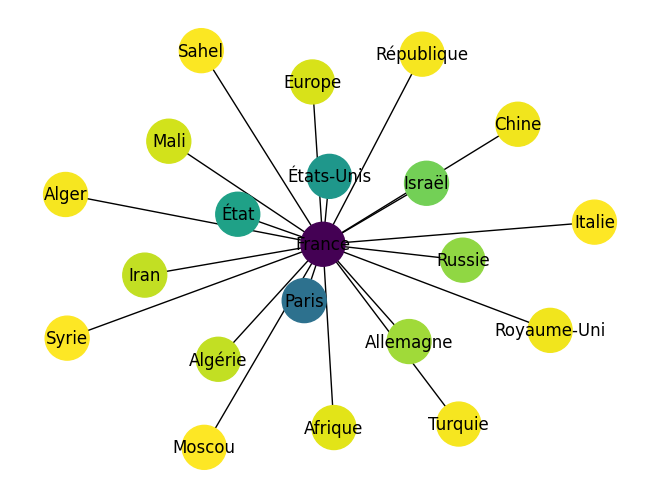

In [72]:
g.add_weighted_edges_from(edges)
g.add_nodes_from(nodes)
n_weight = [i for i in weight]
n_weight[0] = n_weight[1]+ n_weight[1]/2
nx.draw_spring(g,with_labels=True,node_size = 1000,node_color = n_weight,cmap = plt.cm.get_cmap('viridis_r'))

## Récupération des mots clés en fonction de deux localisations

In [68]:
country1 = list(top_location.keys())[0] # Premier localisation (à prendre dans la liste des localisations précédentes)
country2 = list(top_location.keys())[1] # Deuxième localisation (à prendre dans la liste des localisations précédentes)

all_kws, all_apparition = recupKws(country1, country2)

df_kws = createDfBarchar(all_kws, all_apparition, country1, country2)

print(df_kws)


     Keywords  Nb of Apparition  Nb Articles  Nb Apparition per Article
0    français              8050         1810                   4.447514
1        pari              7410         2145                   3.454545
2        pays              5350         1328                   4.028614
3   président              4074         1188                   3.429293
4        état              3634         1145                   3.173799
..        ...               ...          ...                        ...
95    janvier               965          483                   1.997930
96     projet               961          453                   2.121413
97   décision               955          556                   1.717626
98  mouvement               954          479                   1.991649
99    attaque               953          395                   2.412658

[100 rows x 4 columns]


## Création d'un Bar Chart
Nous créons ensuite un graphique mettant en avant les mots clés les plus utilisés lorsque l'on parle de deux localisations.

In [69]:
fig = px.bar(df_kws,title=f'Number of apparition of the most used keywords related {country1} and {country2}',x='Keywords',y='Nb of Apparition',color='Nb Apparition per Article',color_continuous_scale=px.colors.sequential.matter,hover_data=df_kws)
fig.update_layout(xaxis_tickangle=-70)
fig.show()

# Nuage de points 
Ce graphique en nuage de points (également connu sous le nom de nuage de mots ou nuage de tags) est un outil visuel utilisé pour représenter les relations entre différents éléments, en l'occurrence les pays et les mots-clés mentionnés dans les articles liés au pays donné. Il permet d'illustrer les différences dans l'utilisation des mots-clés en fonction des pays mentionnés.

Pour réaliser ce graphique, vous devez d'abord sélectionner un pays racine (par exemple, la France) et rechercher dans tous les articles qui mentionnent ce pays les autres pays qui sont également mentionnés. Ensuite, vous devez compter le nombre de fois où les mots-clés sont mentionnés dans ces articles, et représenter ces données sous la forme d'un nuage de points où l'abscisse correspond au nombre de mentions du premier mot-clé et l'ordonnée au nombre de mentions du deuxième mot-clé.

Ainsi, si vous choisissez les mots-clés "armée" et "arabe" et que vous constatez qu'il y a un nombre élevé de mentions de ces mots-clés lorsqu'on parle de la France et de la Syrie dans les articles, le point représentant la Syrie sera situé tout en haut à droite du graphique. Si, en revanche, il y a peu de mentions de ces mots-clés lorsqu'on parle de la France et de la Chine dans les articles, le point représentant la Chine sera situé beaucoup plus bas sur le graphique.

En utilisant ce graphique, vous pouvez facilement visualiser les différences dans l'utilisation des mots-clés en fonction des pays mentionnés dans les articles liés au pays racine. Cela peut vous aider à mieux comprendre les relations entre ces pays et à identifier des tendances ou des thèmes communs dans leur traitement par les médias.

# Dendrogramme
Une fois que vous avez calculé la distance entre chaque point du nuage de points, vous pouvez utiliser ces données pour créer un dendrogramme. Le dendrogramme représentera les pays comme des branches reliées entre elles, et la distance entre les branches reflétera la distance entre les points correspondants du nuage de points. Plus les branches sont proches les unes des autres, plus les points correspondants du nuage de points sont similaires en termes d'utilisation des mots-clés.

Le dendrogramme vous permet de visualiser les relations entre les pays en fonction de leur utilisation des mots-clés sélectionnés, et vous permet également de voir les regroupements de pays qui utilisent ces mots-clés de manière similaire.


100%|██████████| 4/4 [00:07<00:00,  1.89s/it]


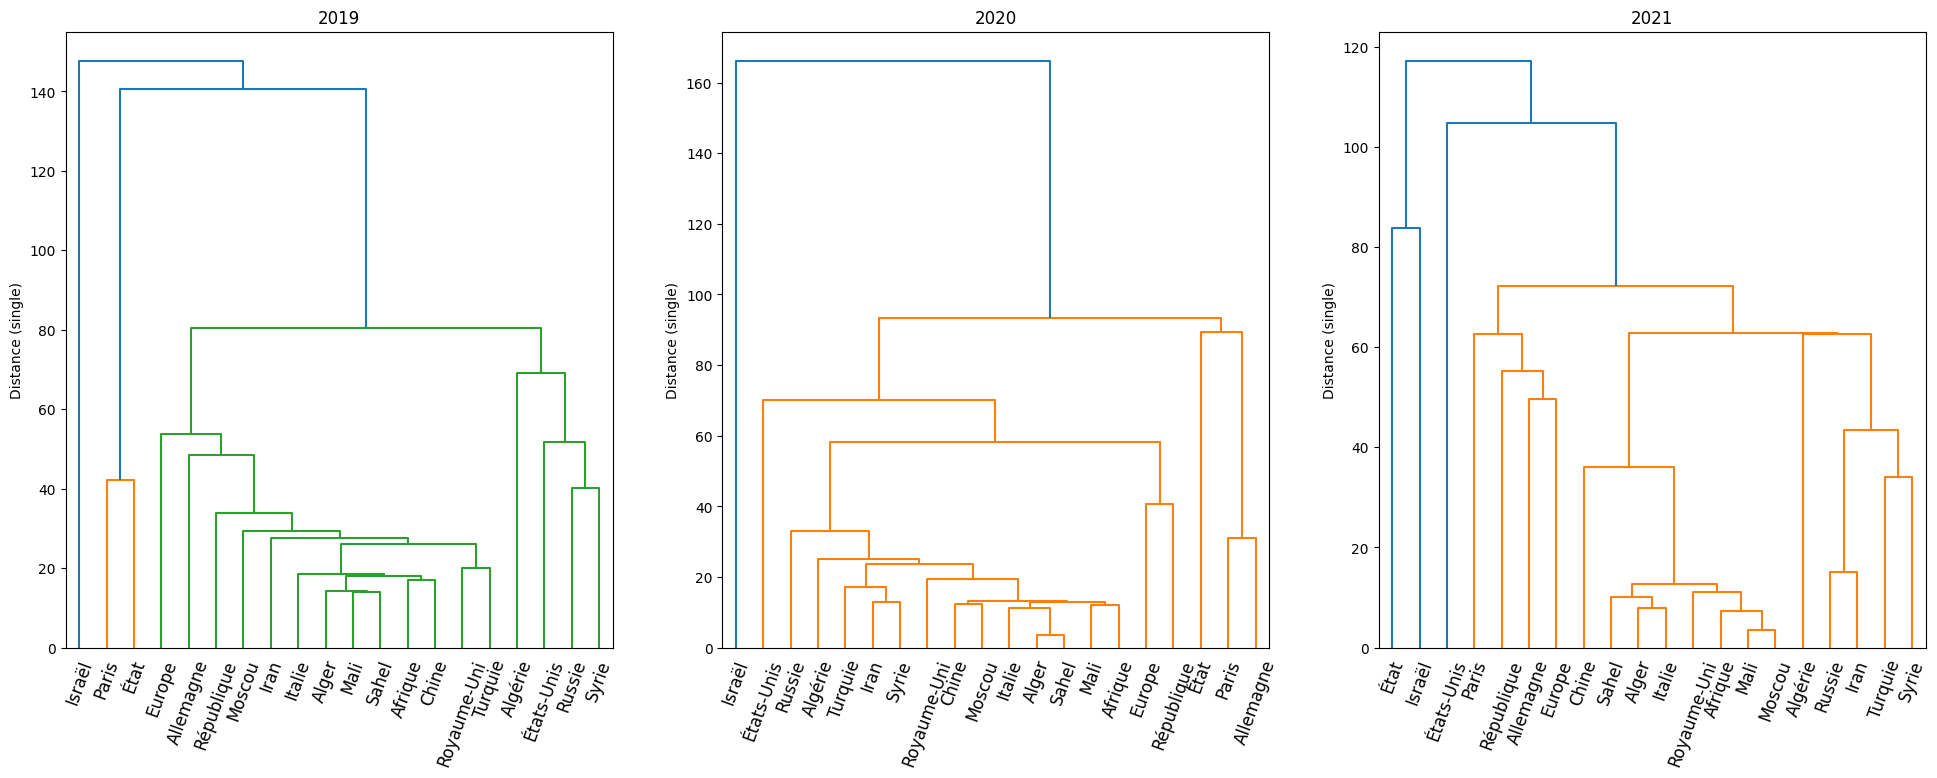

In [74]:
kw1 = "arabe" # A MODIFIER
kw2 = "juif" # A MODIFIER

createScatterGraph(f"{kw1},{kw2}", top_location)